In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
df = pd.read_csv("../data/raw/hiv_cdhit_filtered.csv")

In [6]:
df

,Sequence,MIC,pIC50
0,ACWAAGIKQEF,333.000,8.007368
1,ACWGAGIKQEF,333.000,8.007368
2,ACWWAGIKAEF,333.000,8.007368
3,ACWWAGIKQAF,333.000,8.007368
4,ACWWAGIRQEF,333.000,8.007368
...,...,...,...
148,VWGIKQLQARILAVERYLKDQQLLGIWG,0.020,17.727534
149,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,0.008,18.643824
150,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,0.007,18.777356
151,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,0.005,19.113828


In [7]:
size = len(df['MIC'])-1
df['PL'] = df['MIC'].rank(method='min').apply(lambda x: (x)/size)

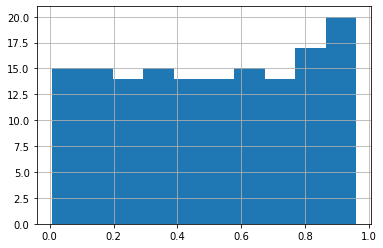

In [8]:
df['PL'].hist()

In [9]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [10]:
aa_freq = reduce_by_kmer_frequency(df)

In [11]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 153/153 [00:00<00:00, 1104.11sequence/s]


In [12]:
physicochemical_prop = get_physicochemical_properties(df)

In [13]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [24]:
y = df[['pIC50', 'MIC']]

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
X_tranformed = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_tranformed, y, test_size=0.2, random_state=42)

In [27]:
y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']

In [28]:
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

In [29]:
def multi_objective_score(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    std_diff = abs(np.std(y_pred) - np.std(y_true))
    return mape + 10*std_diff
multi_objective_scorer = make_scorer(multi_objective_score, greater_is_better=False)

In [30]:
param_grid = {
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': np.arange(0.1,1.0,0.1).round(1).tolist() + np.arange(1,11,1).round().tolist()
}
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=multi_objective_scorer)

In [31]:
grid_search.fit(X_train, y_train_pmic)

Fitting 5 folds for each of 3192 candidates, totalling 15960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 15384 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 15960 out of 15960 | elapsed:   23.9s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring=make_scorer(multi_objective_score, greater_is_better=False),
             verbose=2)

In [63]:
grid_search.best_params_

{'C': 10, 'degree': 1, 'gamma': 3, 'kernel': 'poly'}

In [32]:
best_grid = grid_search.best_estimator_

In [33]:
y_pred_pmic = best_grid.predict(X_test)

In [34]:
mean_absolute_percentage_error(y_test_pmic, y_pred_pmic)

15.184898560217821

In [35]:
np.std(y_test_pmic), np.std(y_pred_pmic)

(1.9624408258222683, 1.7525623970583384)

In [36]:
multi_objective_score(y_test_pmic,y_pred_pmic)

17.283682847857122

In [37]:
mean_squared_error(y_test_pmic,y_pred_pmic)**0.5

1.9328222111174256

### Leave one out CV

In [39]:
loo = LeaveOneOut()

from tqdm import tqdm

result_df = pd.DataFrame(columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train_pmic, y_train_mic = y_train['pIC50'], y_train['MIC']
    y_test_pmic, y_test_mic = y_test['pIC50'], y_test['MIC']
    svr = SVR(**grid_search.best_params_)
    _ = svr.fit(X_train, y_train_pmic)
    y_pred_pmic = svr.predict(X_test)
    y_pred_mic = np.exp(-y_pred_pmic)/1e-6
    ape = 100*np.abs(y_test_pmic-y_pred_pmic)/y_test_pmic
    ape_mic = 100*np.abs(y_test_mic-y_pred_mic)/y_test_mic
    df_val = df.iloc[test_index,:].values[0].tolist()
    res = np.append(df_val, [y_pred_pmic[0], y_pred_mic[0], ape.values[0], ape_mic.values[0]])
    res = pd.DataFrame([res], columns = list(df.columns)+["y_pred_pmic", "y_pred_mic", "ape_pmic", "ape_mic"])
    result_df = result_df.append(res)
result_df = result_df[["Sequence", "pIC50", "y_pred_pmic", "ape_pmic", "MIC", "y_pred_mic", "ape_mic"]]

153it [00:01, 87.34it/s]


In [40]:
result_df#.to_csv("../results/SVM_HIV_CoV_pMIC_to_MIC_rbf_c_100_gamma_2.csv", index=False)

,Sequence,pIC50,y_pred_pmic,ape_pmic,MIC,y_pred_mic,ape_mic
0,ACWAAGIKQEF,8.00736806798383,11.03080735212477,37.75821541449648,333.0,16.195010578840005,95.13663345980781
0,ACWGAGIKQEF,8.00736806798383,11.072206944540396,38.275234141051044,333.0,15.538232712747256,95.33386405022605
0,ACWWAGIKAEF,8.00736806798383,10.970359063133497,37.003307079097674,333.0,17.20416481354883,94.83358414007543
0,ACWWAGIKQAF,8.00736806798383,10.998493034809911,37.35465812775127,333.0,16.72688864579592,94.97691031657781
0,ACWWAGIRQEF,8.00736806798383,11.052433377319675,38.028291986614775,333.0,15.848536800634845,95.24067963944898
...,...,...,...,...,...,...,...
0,VWGIKQLQARILAVERYLKDQQLLGIWG,17.727533563392424,11.189032402737478,36.88331000628893,0.02,13.82499457809041,69024.97289045205
0,MTWMEWDREINNYTSLIHSLIEESQNQQEKNEQELLEL,18.643824295266572,11.260545764065139,39.60173843236633,0.008,12.870846517224841,160785.5814653105
0,MTWEAWDRAIAEYAARIEALIRAAQEQQEKNEAALREL,18.777355687891102,11.028948849315947,41.26463261050036,0.006999999999999999,16.225137037872578,231687.67196960826
0,TTWEEWDREINEYTSRIESLIRESQEQQEKNEQELREL,19.113827924512307,11.230570971399597,41.243737174189576,0.005,13.262487833314012,265149.7566662802


In [41]:
result_df['ape_pmic'].astype('float').mean()

17.545831352794195

In [42]:
result_df['ape_mic'].astype('float').mean()

12626.274402202333

In [43]:
from scipy.stats import pearsonr

In [45]:
pearsonr(result_df['MIC'].astype('float'), result_df['y_pred_mic'].astype('float'))

(0.2586226132293542, 0.001247253779859278)